In [ ]:
import torch
from transformers import ViTForImageClassification
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.optim.lr_scheduler import CosineAnnealingLR
import random
from tqdm import tqdm
import time

## Grayscale Function

In [2]:
def convert_to_grayscale(image):
    grayscale_image = image.convert("L")  # 1-channel
    rgb_grayscale = grayscale_image.convert("RGB")  # Convert back to 3-channel (ViT expects 3 channels)
    return rgb_grayscale

## Dataset Class

In [3]:
class SleepPostureDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = {"0": 0, "1": 1, "2": 2}  # Supine: 0, Left-lying: 1, Right-lying: 2

        for subject in sorted(os.listdir(root_dir)):  # Iterate over subjects
            subject_path = os.path.join(root_dir, subject)
            if not os.path.isdir(subject_path):
                continue

            for category in ["uncover", "cover1", "cover2"]:  # Iterate over categories
                category_path = os.path.join(subject_path, category)
                if not os.path.isdir(category_path):
                    continue

                for img_name in sorted(os.listdir(category_path)):  # Iterate over images
                    img_path = os.path.join(category_path, img_name)

                    # Extract posture label based on image filename (first character)
                    label = self.labels.get(img_name[0], None)
                    if label is not None:
                        self.data.append((img_path, label, category, subject))

        # Split based on subjects (80% train, 20% test)
        subjects = list(set([d[3] for d in self.data]))
        random.seed(42)
        random.shuffle(subjects)
        train_subjects = set(subjects[:int(0.8 * len(subjects))])
        self.data = [d for d in self.data if (d[3] in train_subjects) == train]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label, category, _ = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        image = convert_to_grayscale(image)
        
        if self.transform:
            image = self.transform(image)
        return image, label, category

## Data Augmentation

In [4]:
# Data Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Load Data

In [5]:
dataset_path = '/kaggle/input/slp-dataset'

In [6]:
train_dataset = SleepPostureDataset(root_dir=dataset_path, transform=train_transform, train=True)
test_dataset = SleepPostureDataset(root_dir=dataset_path, transform=test_transform, train=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 11716, Test samples: 2970


In [7]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Visualization (Original vs. Grayscale)

Original vs. Grayscale:


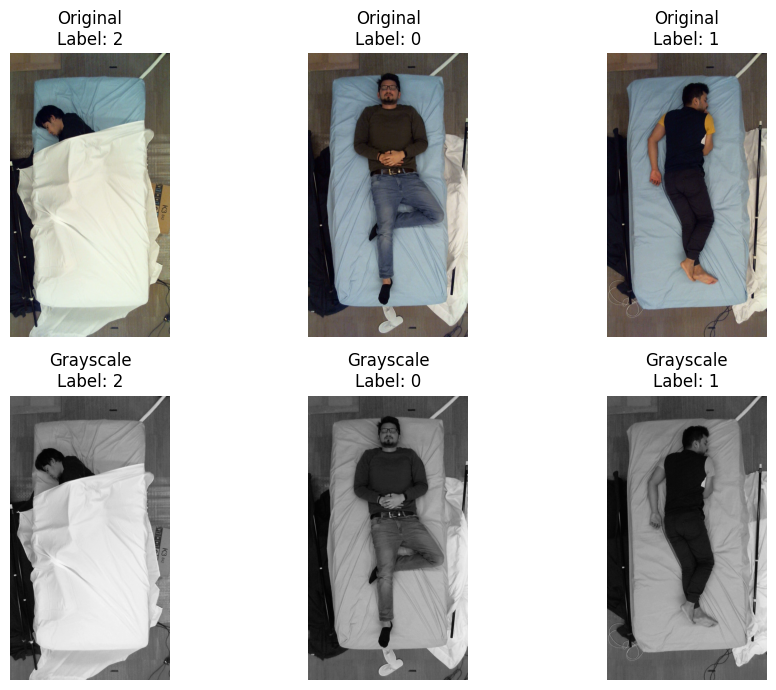

In [8]:
# Visualization function
def display_grayscale_examples(dataset, num_examples=3):
    plt.figure(figsize=(10, 7))
    
    for i in range(num_examples):
        idx = random.randint(0, len(dataset)-1)
        original_image = Image.open(dataset.data[idx][0]).convert("RGB")
        grayscale_image = convert_to_grayscale(original_image)
        
        # Display original
        plt.subplot(2, num_examples, i+1)
        plt.imshow(original_image)
        plt.title(f"Original\nLabel: {dataset.data[idx][1]}")
        plt.axis('off')
        
        # Display grayscale
        plt.subplot(2, num_examples, i+num_examples+1)
        plt.imshow(grayscale_image, cmap='gray')
        plt.title(f"Grayscale\nLabel: {dataset.data[idx][1]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show examples
print("Original vs. Grayscale:")
display_grayscale_examples(train_dataset)

## Visualisation (Original vs. Augmentated)

Original vs. Augmentated:


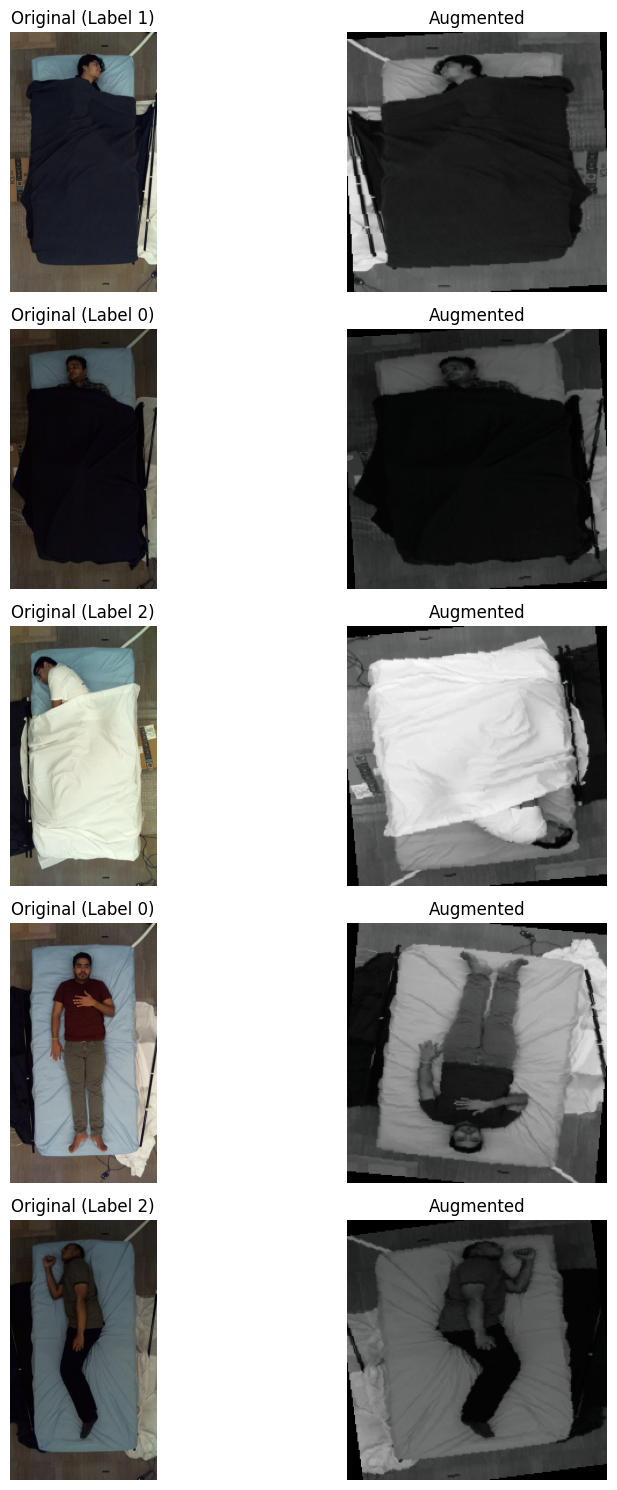

In [9]:
def tensor_to_pil(img_tensor):
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img = np.clip(img, 0, 1)
    img = (img * 255).astype('uint8')
    return Image.fromarray(img)

num_examples = 5
plt.figure(figsize=(10, 15))
for i in range(num_examples):
    # pick a random sample
    path, label, _, _ = train_dataset.data[random.randint(0, len(train_dataset)-1)]
    orig = Image.open(path).convert("RGB")
    gray = convert_to_grayscale(orig)
    aug_tensor = train_transform(gray)
    aug = tensor_to_pil(aug_tensor)
    
    # original
    plt.subplot(num_examples, 2, 2*i+1)
    plt.imshow(orig)
    plt.title(f"Original (Label {label})")
    plt.axis('off')
    
    # augmented
    plt.subplot(num_examples, 2, 2*i+2)
    plt.imshow(aug)
    plt.title("Augmented")
    plt.axis('off')
    
print("Original vs. Augmentated:")
plt.tight_layout()
plt.show()

## Device Setup

In [10]:
#Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Load Pretrained ViT Model

In [11]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch32-224-in21k")
model.classifier = nn.Linear(768, 3)  # Adapt to 3 classes

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Full Fine-Tuning

In [12]:
for param in model.parameters():
    param.requires_grad = True

model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

## Loss, Optimizer & Scheduler

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

## Training Loop

In [14]:
train_predictions = {"uncover": [], "cover1": [], "cover2": []}
train_targets = {"uncover": [], "cover1": [], "cover2": []}

train_losses = []
val_losses = []

num_epochs = 10
total_start = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap train_loader with tqdm
    train_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for images, labels, categories in train_loop:
        images, labels = images.to(device), labels.to(device)
            
        optimizer.zero_grad()
        outputs = model(images).logits
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        train_loop.set_postfix(loss=loss.item(), acc=100*correct/total)

        # Store predictions and labels per category
        preds = predicted.cpu().numpy()
        labels = labels.cpu().numpy()
        for i in range(len(categories)):
            category = categories[i]
            train_predictions[category].append(preds[i])
            train_targets[category].append(labels[i])
    
    # Calculate validation loss after each epoch
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            val_loss += criterion(outputs, labels).item()

    epoch_end = time.time()
    epoch_secs = epoch_end - epoch_start
    
    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    val_loss = val_loss / len(test_loader)
    accuracy = 100 * correct / total
    
    # Store losses for plotting
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    
    print(
        f"Epoch {epoch+1}: "
        f"Train Loss={epoch_loss:.4f}," 
        f"Val Loss={val_loss:.4f}," 
        f"Accuracy={accuracy:.2f}%,"
        f"Time={epoch_secs:.1f}s"
    )

total_end = time.time()
total_secs = total_end - total_start
hrs = total_secs // 3600
mins = (total_secs % 3600) // 60
secs = total_secs % 60

print(f"Total training time: {int(hrs)}h {int(mins)}m {secs:.1f}s")

Epoch 1: Train Loss=0.5583,Val Loss=0.4353,Accuracy=74.68%,Time=480.6s


Epoch 2: Train Loss=0.2126,Val Loss=0.3534,Accuracy=92.74%,Time=484.0s


Epoch 3: Train Loss=0.1321,Val Loss=0.2598,Accuracy=95.73%,Time=484.3s


Epoch 4: Train Loss=0.0923,Val Loss=0.2210,Accuracy=96.80%,Time=483.9s


Epoch 5: Train Loss=0.0653,Val Loss=0.2039,Accuracy=97.93%,Time=486.6s


Epoch 6: Train Loss=0.0483,Val Loss=0.2494,Accuracy=98.47%,Time=483.6s


Epoch 7: Train Loss=0.0343,Val Loss=0.2110,Accuracy=98.94%,Time=478.4s


Epoch 8: Train Loss=0.0252,Val Loss=0.2157,Accuracy=99.31%,Time=486.4s


Epoch 9: Train Loss=0.0196,Val Loss=0.2038,Accuracy=99.46%,Time=485.1s


Epoch 10: Train Loss=0.0172,Val Loss=0.2027,Accuracy=99.57%,Time=481.0s
Total training time: 1h 20m 33.8s


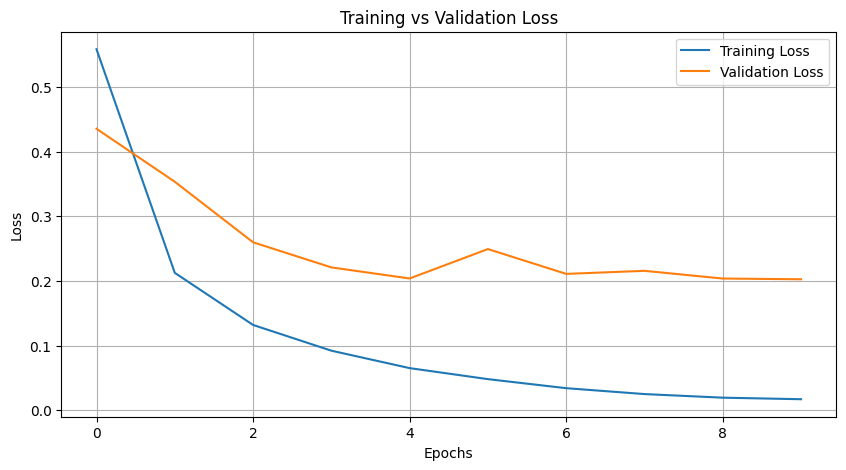

In [15]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

## Final Evaluation and Results

### Training Results


=== Training Results for uncover ===
              precision    recall  f1-score   support

      Supine       0.98      0.98      0.98     13050
  Left-lying       0.97      0.96      0.96     12910
 Right-lying       0.96      0.96      0.96     12900

    accuracy                           0.97     38860
   macro avg       0.97      0.97      0.97     38860
weighted avg       0.97      0.97      0.97     38860


Per-Class Accuracy:
Supine: 0.9819
Left-lying: 0.9582
Right-lying: 0.9644


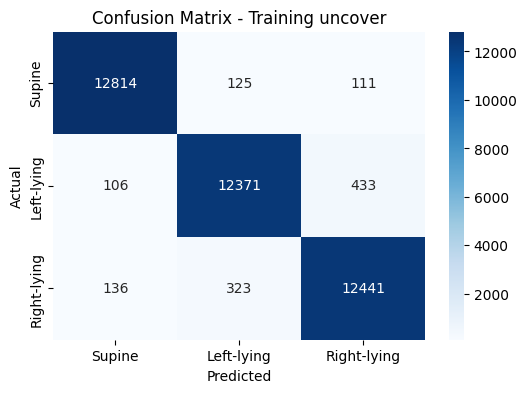


=== Training Results for cover1 ===
              precision    recall  f1-score   support

      Supine       0.96      0.96      0.96     13050
  Left-lying       0.94      0.94      0.94     13050
 Right-lying       0.95      0.95      0.95     13050

    accuracy                           0.95     39150
   macro avg       0.95      0.95      0.95     39150
weighted avg       0.95      0.95      0.95     39150


Per-Class Accuracy:
Supine: 0.9625
Left-lying: 0.9372
Right-lying: 0.9462


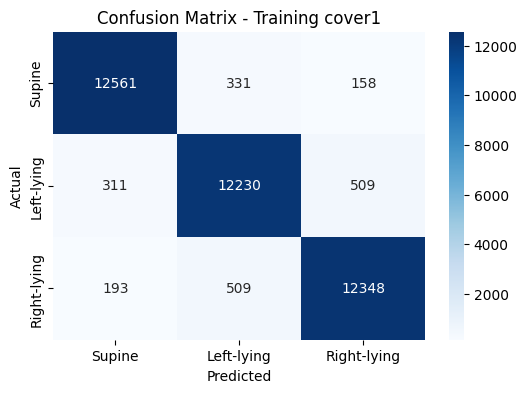


=== Training Results for cover2 ===
              precision    recall  f1-score   support

      Supine       0.96      0.96      0.96     13050
  Left-lying       0.93      0.94      0.93     13050
 Right-lying       0.94      0.94      0.94     13050

    accuracy                           0.94     39150
   macro avg       0.94      0.94      0.94     39150
weighted avg       0.94      0.94      0.94     39150


Per-Class Accuracy:
Supine: 0.9615
Left-lying: 0.9350
Right-lying: 0.9361


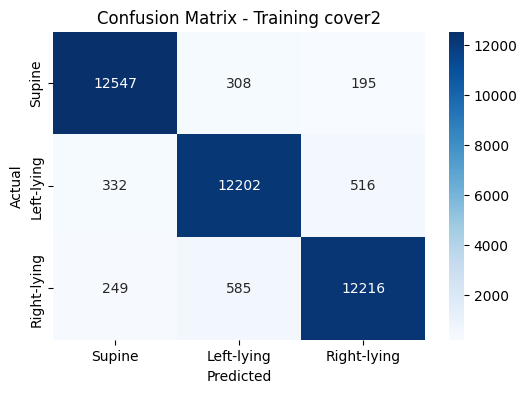

In [16]:
class_names = ["Supine", "Left-lying", "Right-lying"]

for category in ["uncover", "cover1", "cover2"]:
    print(f"\n=== Training Results for {category} ===")

    # Generate classification report
    train_report = classification_report(train_targets[category], train_predictions[category], target_names=class_names, output_dict=True)

    # Print overall classification report
    print(classification_report(train_targets[category], train_predictions[category], target_names=class_names))

    # Extract per-class accuracy
    train_cm = confusion_matrix(train_targets[category], train_predictions[category])
    train_per_class_accuracy = train_cm.diagonal() / train_cm.sum(axis=1)

    print("\nPer-Class Accuracy:")
    for i, posture in enumerate(class_names):
        print(f"{posture}: {train_per_class_accuracy[i]:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Training {category}")
    plt.show()


=== Overall Training Results ===
              precision    recall  f1-score   support

      Supine       0.97      0.97      0.97     39150
  Left-lying       0.94      0.94      0.94     39010
 Right-lying       0.95      0.95      0.95     39000

    accuracy                           0.95    117160
   macro avg       0.95      0.95      0.95    117160
weighted avg       0.95      0.95      0.95    117160


Overall Training Per-Class Accuracy:
Supine: 0.9686
Left-lying: 0.9434
Right-lying: 0.9488


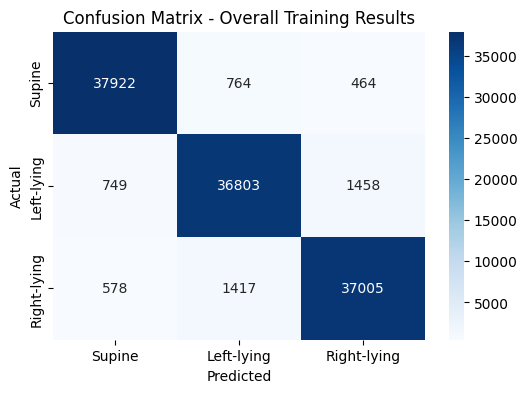

In [17]:
# Store overall training predictions and labels
overall_train_predictions = []
overall_train_targets = []

# Ensure per-category predictions are lists before appending
for category in ["uncover", "cover1", "cover2"]:
    train_predictions[category] = list(train_predictions[category])  # Convert NumPy array to list
    train_targets[category] = list(train_targets[category])  # Convert NumPy array to list

# Collect overall training data
for category in ["uncover", "cover1", "cover2"]:
    overall_train_predictions.extend(train_predictions[category])
    overall_train_targets.extend(train_targets[category])

# Convert lists to NumPy arrays for further processing
overall_train_predictions = np.array(overall_train_predictions)
overall_train_targets = np.array(overall_train_targets)

# Print overall classification report
print("\n=== Overall Training Results ===")
print(classification_report(overall_train_targets, overall_train_predictions, target_names=class_names))

# Compute overall confusion matrix
overall_train_cm = confusion_matrix(overall_train_targets, overall_train_predictions)
overall_train_per_class_accuracy = overall_train_cm.diagonal() / overall_train_cm.sum(axis=1)

print("\nOverall Training Per-Class Accuracy:")
for i, posture in enumerate(class_names):
    print(f"{posture}: {overall_train_per_class_accuracy[i]:.4f}")

# Plot overall confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(overall_train_cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Overall Training Results")
plt.show()

### Testing Results


=== Testing Results for uncover ===
              precision    recall  f1-score   support

      Supine       0.99      0.95      0.97       330
  Left-lying       0.98      0.95      0.96       330
 Right-lying       0.91      0.99      0.95       330

    accuracy                           0.96       990
   macro avg       0.96      0.96      0.96       990
weighted avg       0.96      0.96      0.96       990


Per-Class Accuracy:
Supine: 0.9455
Left-lying: 0.9485
Right-lying: 0.9879


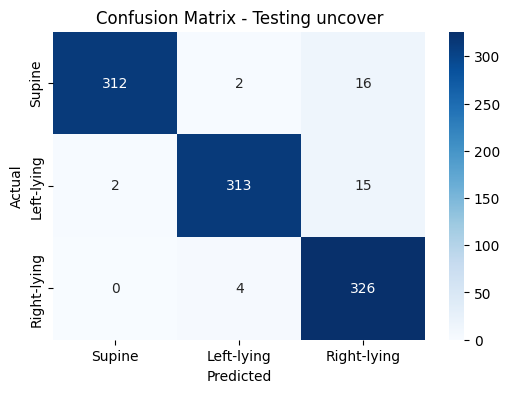


=== Testing Results for cover1 ===
              precision    recall  f1-score   support

      Supine       0.98      0.92      0.95       330
  Left-lying       0.94      0.95      0.94       330
 Right-lying       0.92      0.97      0.94       330

    accuracy                           0.94       990
   macro avg       0.95      0.94      0.94       990
weighted avg       0.95      0.94      0.94       990


Per-Class Accuracy:
Supine: 0.9182
Left-lying: 0.9455
Right-lying: 0.9697


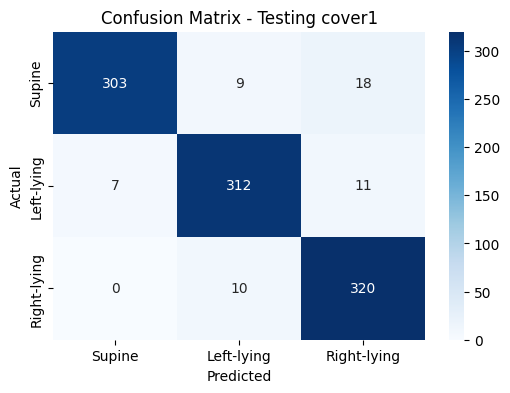


=== Testing Results for cover2 ===
              precision    recall  f1-score   support

      Supine       0.96      0.89      0.92       330
  Left-lying       0.92      0.92      0.92       330
 Right-lying       0.88      0.94      0.91       330

    accuracy                           0.92       990
   macro avg       0.92      0.92      0.92       990
weighted avg       0.92      0.92      0.92       990


Per-Class Accuracy:
Supine: 0.8879
Left-lying: 0.9242
Right-lying: 0.9424


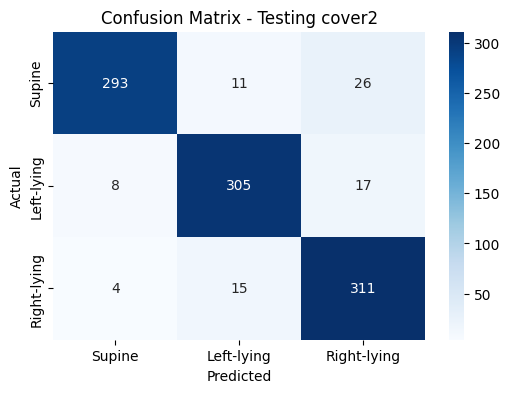

In [18]:
model.eval()

# Store predictions and targets for each category
predictions = {"uncover": [], "cover1": [], "cover2": []}
targets = {"uncover": [], "cover1": [], "cover2": []}

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels, categories in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        # Store predictions and labels per category
        for i in range(len(categories)):
            category = categories[i]
            predictions[category].append(preds[i])
            targets[category].append(labels[i])

# Convert lists to numpy arrays for processing
for category in ["uncover", "cover1", "cover2"]:
    predictions[category] = np.array(predictions[category])
    targets[category] = np.array(targets[category])

# Define class names
class_names = ["Supine", "Left-lying", "Right-lying"]

# Print classification reports & confusion matrices
for category in ["uncover", "cover1", "cover2"]:
    print(f"\n=== Testing Results for {category} ===")

    # Generate classification report
    report = classification_report(targets[category], predictions[category], target_names=class_names, output_dict=True)

    # Print overall classification report
    print(classification_report(targets[category], predictions[category], target_names=class_names))

    # Extract per-class accuracy
    cm = confusion_matrix(targets[category], predictions[category])
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

    print("\nPer-Class Accuracy:")
    for i, posture in enumerate(class_names):
        print(f"{posture}: {per_class_accuracy[i]:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Testing {category}")
    plt.show()


=== Overall Testing Results ===
              precision    recall  f1-score   support

      Supine       0.98      0.92      0.95       990
  Left-lying       0.95      0.94      0.94       990
 Right-lying       0.90      0.97      0.93       990

    accuracy                           0.94      2970
   macro avg       0.94      0.94      0.94      2970
weighted avg       0.94      0.94      0.94      2970


Overall Testing Per-Class Accuracy:
Supine: 0.9172
Left-lying: 0.9394
Right-lying: 0.9667


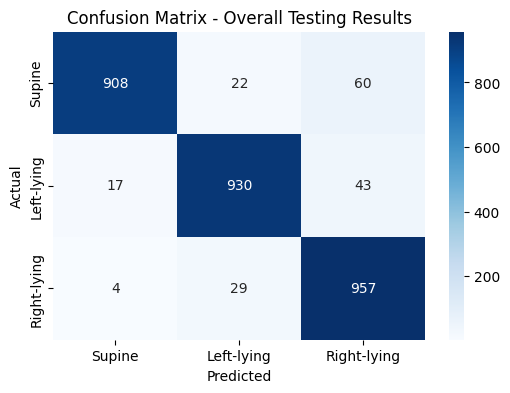

In [19]:
# Store overall predictions and targets
overall_predictions = []
overall_targets = []

# Ensure per-category predictions are lists before appending
for category in ["uncover", "cover1", "cover2"]:
    predictions[category] = list(predictions[category])  # Convert NumPy array to list
    targets[category] = list(targets[category])  # Convert NumPy array to list

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels, categories in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        # Store predictions and labels per category
        for i in range(len(categories)):
            category = categories[i]
            predictions[category].append(preds[i])  # Now appending to a list
            targets[category].append(labels[i])  # Now appending to a list

        # Store overall predictions and labels
        overall_predictions.extend(preds)
        overall_targets.extend(labels)

# Convert lists to NumPy arrays for further processing
overall_predictions = np.array(overall_predictions)
overall_targets = np.array(overall_targets)

# Define class names
class_names = ["Supine", "Left-lying", "Right-lying"]

# Print overall classification report
print("\n=== Overall Testing Results ===")
overall_report = classification_report(overall_targets, overall_predictions, target_names=class_names)
print(overall_report)

# Compute overall confusion matrix
overall_cm = confusion_matrix(overall_targets, overall_predictions)
overall_per_class_accuracy = overall_cm.diagonal() / overall_cm.sum(axis=1)

print("\nOverall Testing Per-Class Accuracy:")
for i, posture in enumerate(class_names):
    print(f"{posture}: {overall_per_class_accuracy[i]:.4f}")

# Plot overall confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(overall_cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Overall Testing Results")
plt.show()

In [20]:
torch.save(model.state_dict(), 'ViT-B16@224.pth')